# CASA0007 - Quantitative Methods Group Project
## Group 25

## Meeting Plan (05/12/2022)
- Change text back to OA data. 
- Calculate distacne from OA to central London - Joe
- Create regression model, then move to multiple regression model - Zach
- Tests the assumptions of linear regression. Scatter plots, + of risiduals to identify independence, equal varience and colinearility.  - Zach
- Clustering analysis of distance, deprivation and air quality

In [2]:
#Reading in libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import precision_score

## 1. Context of the data

### 1.0. Aggregation Level - Zach

Data is aggregated to the Output Area (OA) Level. This being the smallest level of aggregation that the census data is released on by the ONS (Office of National Statistics). 
- Each OA contains between 40 and 250 households, leading to an estimated population of between 100 and 625. 
- **Limitation** of aggregation level: OAs change between each census (10 year lifecycle) due to variation in population density, meaning data cannot always be compared between census' easily. 




**UK Administrative Units**
1. Output Areas (OAs)
2. Lower Super Output Areas (LSOAs)
3. Middle layer Super Output Areas (MSOAs)
4. Boroughs/ Local Administrative Unit (LAD)


### 1.1. Cycling to work: Census Data
This dataset is from the 2011 Census. Results are based off a Census question that classifies usual residents aged 16 to 74 in England and Wales by their method of travel to work, disaggregated by Census Output Area (OA). The estimates are as at census day, 27 March 2011 (single time snapshot). The dataset can be found [here](https://www.nomisweb.co.uk/census/2011/qs701ew).  

**Cycling Behaviour (TO REMOVE)**   
This dataset reports level of cycling activity across local authority districts in England. The data are collected from the Active Lives Survey (ALS), a bi-annual residential household survey administered by Sport England. Sport England is an independent government body associated with the Department for Digital, Culture, Media and Sport.  

The dataset used covers the period mid-November 2018 to  mid-November 2019. The dataset can be found [here](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1100942/cw0302.ods).


### 1.2. Deprivation - Yubin

The dataset measured the index of deprivation based on seven different domains across 319 local authority districts in England, published by the Ministry of Housing, Communities and Local Government on 26 September 2019.

The seven domains in the measure of deprivation are:
1. Income Deprivation: The proportion of the population experiencing deprivation relating to low income group, those people that are out-of-work or low earnings  
2. Employment Deprivation: The proportion of the working-age population in an area who are excluded from the labor market due to unemployment, sickness or disability, or caring responsibilities.
3. Education, Skills and Training Deprivation: The lack of attainment and skills in the local population. The indicators fall into two sub-domains: one relating to children and young people and one relating to adult skills. 
4. Health Deprivation and Disability: The risk of premature death and the impairment of quality of life through poor physical or mental health. 
5. Crime: The risk of personal and material victimization at local level. 
6. Barriers to Housing and Services: The physical and financial accessibility of housing and local services, including the access to affordable housing and the physical proximity of local services
7. Living Environment Deprivation: The quality of the local environment includes the quality of housing, neighborhood air quality and road traffic accidents.



### 1.3. Air Quality - Zach [[Data](https://data.london.gov.uk/dataset/pm2-5-map-and-exposure-data)]

This dataset identifies modelled PM<sub>2.5 </sub>(particulate matter of diameter 2.5 micrometers or less) across London's Output Areas. 
- Modelled by Tfl (Transport for London) and GLA (Greater London Authority)

Increased exposure to high levels of partculate matter have been linked to increased rate of cardiovascular and respiratory disease (Liu, 2019). 

This data is being considered due to the assumption that emission levels infulence the decision making process of commuters. This emissions data could be used as a proxy for volume of motor vehicles, or considered as a variable having an impact by itself on decision making.



| Variable| Unit | Description |
| --- | --- | --- |
| PM<sub>2.5 </sub> | µg/m<sup>3 </sup>| Modelled concentration of particulate matter with diameter or 2.5 micrometers or less. | 


**Limitations:**
- Assuming causality of air quality and commuting choice would be incorrect. It is possible that air pollution is low due to choice of pollution. Suggesting an inverse relationship to that initally proposed. 


### 1.4. Cycle Sharing

## 2. Description of data fields/ variables

### 2.1. Cycling Behaviour - Joe
* Read in the data

In [210]:
# cycletowork = pd.read_csv('data/oa/cycleing_to_work_oa.csv')

#MSOA data
cycletowork = pd.read_csv('data/msoa/cyclingtowork_2011census_msoa.csv')

# print(cycletowork.columns)
print(cycletowork.shape)

(7201, 17)


* Drop unnecessary columns

In [211]:
cycletowork = cycletowork[['date',
                           'geography code',
                           'Method of Travel to Work: Bicycle; measures: Value',
                           'Method of Travel to Work: All categories: Method of travel to work; measures: Value']]
cycletowork.columns

Index(['date', 'geography code',
       'Method of Travel to Work: Bicycle; measures: Value',
       'Method of Travel to Work: All categories: Method of travel to work; measures: Value'],
      dtype='object')

* Rename columns to clean format

In [212]:
cycletowork.rename(columns = {'date':'year',
                              'geography code':'oa_code',
                              'Method of Travel to Work: Bicycle; measures: Value':'cycling_count',
                              'Method of Travel to Work: All categories: Method of travel to work; measures: Value':'total_count'}, 
                   inplace = True)

* Calculate cycling rate (standardised value)

In [213]:
cycletowork['cycling_rate'] = cycletowork['cycling_count']/cycletowork['total_count']

In [214]:
cycletowork.dtypes

year               int64
oa_code           object
cycling_count      int64
total_count        int64
cycling_rate     float64
dtype: object

The relevant fields for our analysis are as follows:
| Original name  | Cleaned name | Data type  | Description  |
|---|---|---|---|
| Date  | year | Integer  | Year data  was collected (2011 census).  |
| Geography code  | oa_code | String  | Census Output Area unique identifier. The string code can be used to filter OAs by UK region.  |
| Method of Travel to Work: Bicycle  | cycling_count | Integer  | Count of residents aged 16 to 74 who used a bicycle as their method of travel to work on the Census date.  |
| Method of Travel to Work: All categories  | total_count | Integer  | Total count of residents aged 16 to 74 who provided a response for method of travel to work on the census date.  |
| N/A  | cycling_rate | Float (decimal)  | Count of cyclists divided by the total count of travellers to work in output area  |
   

### 2.2. Deprivation

In [12]:
depri_income_2019 = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/2019_Deprivation_income.csv')
depri_income_2019.head(10)

,Local Authority District code (2019),Local Authority District name (2019),Income - Average rank,Income - Rank of average rank,Income - Average score,Income - Rank of average score,Income - Proportion of LSOAs in most deprived 10% nationally,Income - Rank of proportion of LSOAs in most deprived 10% nationally,Income scale,Rank of Income Scale
0,E06000001,Hartlepool,23509.14,16,0.228,5,0.3793,7,21084,110
1,E06000002,Middlesbrough,23950.79,9,0.251,1,0.5000,1,34959,59
2,E06000003,Redcar and Cleveland,20604.49,50,0.186,28,0.2614,24,25142,96
3,E06000004,Stockton-on-Tees,18291.93,99,0.164,51,0.2167,33,31750,74
4,E06000005,Darlington,18361.47,94,0.153,69,0.1846,41,16208,133
5,E06000006,Halton,20664.75,48,0.185,30,0.2911,15,23382,101
6,E06000007,Warrington,14196.32,179,0.109,154,0.0630,116,22389,107
7,E06000008,Blackburn with Darwen,23232.88,18,0.212,10,0.3297,10,31358,75
8,E06000009,Blackpool,25404.24,1,0.247,3,0.3617,8,34610,61
9,E06000010,"Kingston upon Hull, City of",23888.21,11,0.227,6,0.4217,4,58544,14


### 2.3. Air Quality - Zach

In [165]:
#Reading in data
aq_df = pd.read_csv("data/oa/OA2_PM25_2013.csv")

In [166]:
#Identifying usable columns
aq_df.head()

,OA11CD,LAD11NM,PM252013me
0,E00024024,Westminster,17.953073
1,E00023833,Westminster,18.183844
2,E00023830,Westminster,18.732058
3,E00023831,Westminster,17.909357
4,E00024021,Westminster,17.185809


Columns:
- OA11CD refers to the unique Output Area code, allowing merging with other data as an explanatory variable. 
- LAD11NM refers to the Borough (three levels of aggregation above OAs) that the OA is within. Boroughs are local administrative units that resources are allocatacted to, which are then distributed across the OAs dependnent on needs. 

### 2.4. Cycle Sharing

## 3. Summary statistic fields

### 3.1. Cycling to work - Joe

In [215]:
cycletowork.describe()

,year,cycling_count,total_count,cycling_rate
count,7201.0,7201.000000,7201.000000,7201.000000
mean,2011.0,105.865019,5711.226219,0.017934
std,0.0,120.777752,1243.733145,0.017921
min,2011.0,2.000000,1622.000000,0.000391
25%,2011.0,41.000000,4766.000000,0.007551
50%,2011.0,68.000000,5539.000000,0.012391
75%,2011.0,126.000000,6407.000000,0.021843
max,2011.0,1824.000000,15222.000000,0.246464


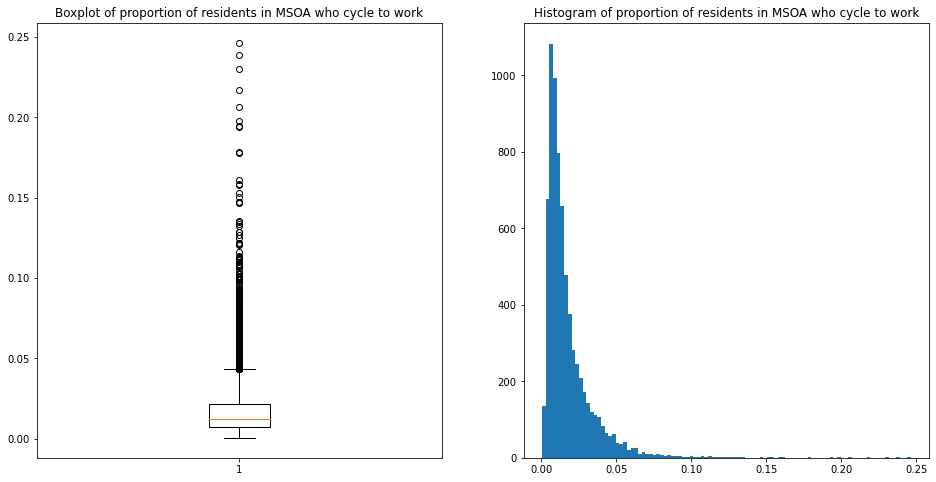

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.boxplot(cycletowork.cycling_rate,
           vert = True)
ax1.set_title("Boxplot of proportion of residents in MSOA who cycle to work")
ax2.hist(cycletowork.cycling_rate,
        bins = 100)
ax2.set_title("Histogram of proportion of residents in MSOA who cycle to work")
plt.show()

### 3.2. Deprivation - Yubin

### 3.3. Air Quality - Zach

In [48]:
aq_df.describe()

,PM252013me
count,25946.000000
mean,16.001274
std,0.788874
min,14.283266
25%,15.417784
50%,15.873302
75%,16.464573
max,21.100099


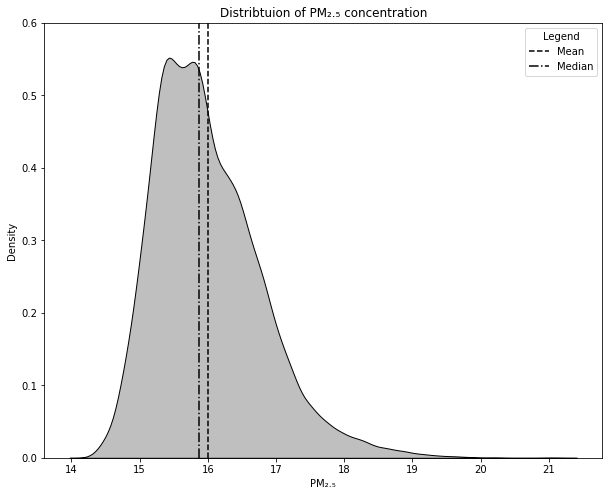

In [49]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.kdeplot(aq_df["PM252013me"], ax=ax, color="black", shade=True)
plt.xlabel("PM\u2082.\u2085")
plt.vlines(aq_df["PM252013me"].mean(), 0, 0.65, linestyle="--", color="black", label="Mean")
plt.vlines(aq_df["PM252013me"].median(), 0, 0.65, linestyle="-.", color="black", label="Median")
plt.legend(title="Legend")
plt.title("Distribtuion of PM\u2082.\u2085 concentration")
plt.ylim(0,0.60)
plt.savefig("figures/aq_kdeplot.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

Data appears to be positvely skewed. Would applying a log fix it?

In [167]:
aq_df["dif_mean"] = aq_df["PM252013me"] - aq_df["PM252013me"].mean()

In [168]:
aq_df["dif_mean_and_std"] = aq_df["dif_mean"] / aq_df["PM252013me"].std()

In [169]:
#Applying a log function to the data
aq_df["PMlog"] = np.log(aq_df["PM252013me"])

None of which normalise the data

### 3.4. Cycle Sharing - 

## 4. Appropriate plots to communicate distribution

### 4.0. Merging of data

In [160]:
#ZPE importing here as importing from link didn't work for me
deprivation = pd.read_csv("data/oa/deprivation_oa.csv")

In [161]:
#Import correspondence file
oa_to_msoa = pd.read_csv("data/msoa/oa_to_msoa_correspondence.csv")
# oa_to_msoa.dtypes

In [162]:
#Merge deprivation dataset to OA/MSOA correspondence file
dep_msoa = deprivation.merge(oa_to_msoa, how='left', left_on='geography code', right_on='OA11CD')
dep_msoa.shape

(25053, 27)

In [197]:
dep_sum.columns

Index(['MSOA11CD', 'MSOA11NM',
       'Household Deprivation: All categories: Classification of household deprivation; measures: Value',
       'Household Deprivation: Household is not deprived in any dimension; measures: Value',
       'Household Deprivation: Household is deprived in 1 dimension; measures: Value',
       'Household Deprivation: Household is deprived in 2 dimensions; measures: Value',
       'Household Deprivation: Household is deprived in 3 dimensions; measures: Value',
       'Household Deprivation: Household is deprived in 4 dimensions; measures: Value'],
      dtype='object')

In [198]:
#Summarise deprivation statistics by MSOA
dep_sum = dep_msoa.groupby(['MSOA11CD', 'MSOA11NM']).agg(
    {
       'Household Deprivation: All categories: Classification of household deprivation; measures: Value':sum,
       'Household Deprivation: Household is not deprived in any dimension; measures: Value':sum,
       'Household Deprivation: Household is deprived in 1 dimension; measures: Value':sum,
       'Household Deprivation: Household is deprived in 2 dimensions; measures: Value':sum,
       'Household Deprivation: Household is deprived in 3 dimensions; measures: Value':sum,
       'Household Deprivation: Household is deprived in 4 dimensions; measures: Value':sum,
    }
)

dep_sum = dep_sum.reset_index(level=[0,1])

dep_sum.rename(columns = {'Household Deprivation: All categories: Classification of household deprivation; measures: Value':'hhdep_all',
                          'Household Deprivation: Household is not deprived in any dimension; measures: Value':'hhdep_0',
                          'Household Deprivation: Household is deprived in 1 dimension; measures: Value':'hhdep_1',
                          'Household Deprivation: Household is deprived in 2 dimensions; measures: Value':'hhdep_2',
                          'Household Deprivation: Household is deprived in 3 dimensions; measures: Value':'hhdep_3',
                          'Household Deprivation: Household is deprived in 4 dimensions; measures: Value':'hhdep_4'
                         }, 
                   inplace = True)

dep_sum.shape

(983, 8)

In [170]:
#Merge air quality datset to OA/MSOA correspondence file
aq_msoa = aq_df.merge(oa_to_msoa, how='left', on='OA11CD')
aq_msoa.shape

(25946, 22)

In [191]:
#Summarise air quality statistics by MSOA
aq_sum = aq_msoa.groupby(['MSOA11CD', 'MSOA11NM'])['PM252013me'].mean()
aq_sum = aq_sum.reset_index(level=[0,1])
aq_sum.shape

(983, 3)

* Merge the three datasets together by MSOA Code

In [113]:
# Comment out this cell to use MSOA cycling data loaded above

# cycletowork = pd.read_csv("data/oa/cycleing_to_work_oa.csv")

#Merging the cycle to work data to deprivation data to form a main dataframe
# df = cycletowork.merge(deprivation, how="left", on="geography code")

In [217]:
cycletowork.head(5)

,year,oa_code,cycling_count,total_count,cycling_rate
0,2011,E02002559,58,6521,0.008894
1,2011,E02002560,76,4462,0.017033
2,2011,E02002561,56,4342,0.012897
3,2011,E02002562,76,4473,0.016991
4,2011,E02002563,75,3912,0.019172


In [218]:
# Add the cycling dataset to the deprivation
df = dep_sum.merge(cycletowork, how = "left", left_on="MSOA11CD", right_on="oa_code")

In [219]:
#Adding the air quality data to the main dataframe
df = df.merge(aq_sum, how = "left", on="MSOA11CD")

In [220]:
df.shape

(983, 15)

In [221]:
#Identifying any NA values
df.isna().sum().reset_index().rename(columns={"index":"Column Name", 0:"Quantity of NAs"})

,Column Name,Quantity of NAs
0,MSOA11CD,0
1,MSOA11NM_x,0
2,hhdep_all,0
3,hhdep_0,0
4,hhdep_1,0
5,hhdep_2,0
6,hhdep_3,0
7,hhdep_4,0
8,year,0
9,oa_code,0


No NA values present within the dataset

In [222]:
#Removing any duplicated rows.
df = df.drop_duplicates(keep="first")

### 4.0 Merging Data Attempt 1 - YUBIN

In [13]:
income_1 = depri_income_2019.merge(cycling_2019, how="left", on="Local Authority District code (2019)")

In [14]:
income_1.isna().sum().reset_index().rename(columns={"index":"Column Name", 0:"Quantity of NAs"})

,Column Name,Quantity of NAs
0,Local Authority District code (2019),0
1,Local Authority District name (2019),0
2,Income - Average rank,0
3,Income - Rank of average rank,0
4,Income - Average score,0
5,Income - Rank of average score,0
6,Income - Proportion of LSOAs in most deprived ...,0
7,Income - Rank of proportion of LSOAs in most d...,0
8,Income scale,0
9,Rank of Income Scale,0


In [15]:
income_1 = income_1.drop_duplicates(keep="first")

In [21]:
income_1.head(20)

,Local Authority District code (2019),Local Authority District name (2019),Income - Average rank,Income - Rank of average rank,Income - Average score,Income - Rank of average score,Income - Proportion of LSOAs in most deprived 10% nationally,Income - Rank of proportion of LSOAs in most deprived 10% nationally,Income scale,Rank of Income Scale,...,Any cycling Three times per week,Any cycling Five times per week,Cycling for leisure Once per month,Cycling for leisure Once per week,Cycling for leisure Three times per week,Cycling for leisure Five times per week,Cycling for travel Once per month,Cycling for travel Once per week,Cycling for travel Three times per week,Cycling for travel Five times per week
0,E06000001,Hartlepool,23509.14,16,0.228,5,0.3793,7,21084,110,...,2.9,1.3,8.0,5.5,1.5,0.2,3.2,1.7,0.9,0.9
1,E06000002,Middlesbrough,23950.79,9,0.251,1,0.5000,1,34959,59,...,3.3,2.9,9.9,4.8,2.4,2.0,4.6,3.9,2.6,1.9
2,E06000003,Redcar and Cleveland,20604.49,50,0.186,28,0.2614,24,25142,96,...,4.7,2.5,15.8,13.3,2.7,0.9,7.8,4.4,1.7,0.3
3,E06000004,Stockton-on-Tees,18291.93,99,0.164,51,0.2167,33,31750,74,...,3.4,1.4,11.9,6.9,1.4,0.9,7.2,6.1,0.9,0.5
4,E06000005,Darlington,18361.47,94,0.153,69,0.1846,41,16208,133,...,3.8,2.6,10.5,7.6,2.7,1.1,6.7,3.3,2.1,1.0
5,E06000006,Halton,20664.75,48,0.185,30,0.2911,15,23382,101,...,5.9,3.3,10.6,8.1,3.8,1.9,5.4,4.8,2.9,2.4
6,E06000007,Warrington,14196.32,179,0.109,154,0.0630,116,22389,107,...,6.9,4.8,14.1,9.8,5.5,3.6,8.1,6.7,2.4,2.1
7,E06000008,Blackburn with Darwen,23232.88,18,0.212,10,0.3297,10,31358,75,...,2.5,1.8,7.5,4.6,2.1,1.5,4.6,1.1,0.3,0.0
8,E06000009,Blackpool,25404.24,1,0.247,3,0.3617,8,34610,61,...,3.6,2.6,14.8,7.5,1.7,0.7,6.6,5.8,2.2,1.8
9,E06000010,"Kingston upon Hull, City of",23888.21,11,0.227,6,0.4217,4,58544,14,...,7.8,3.5,12.2,8.7,3.9,0.4,11.0,7.5,4.7,1.5


### 4.1. Basic Plotting

Need to normalise both deprivation and cycle to work datasets before using!

#### 4.1.1 Cycle to work and Deprivation

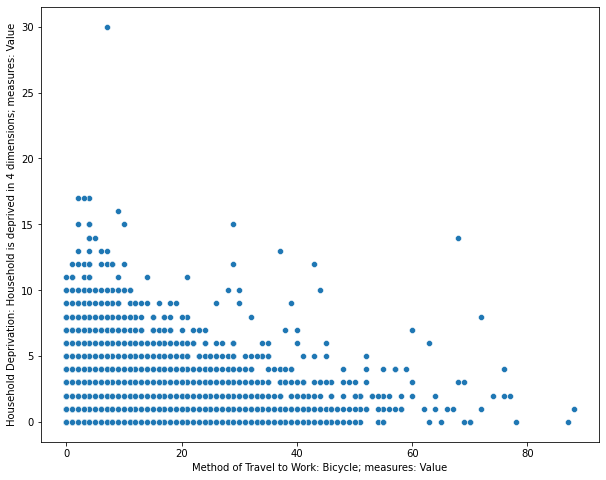

In [60]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.scatterplot(data = df, x="Method of Travel to Work: Bicycle; measures: Value", 
            y="Household Deprivation: Household is deprived in 4 dimensions; measures: Value", ax=ax)
                       
plt.show()

Hard to identify relationship? Might be difficult to plot a regression line.

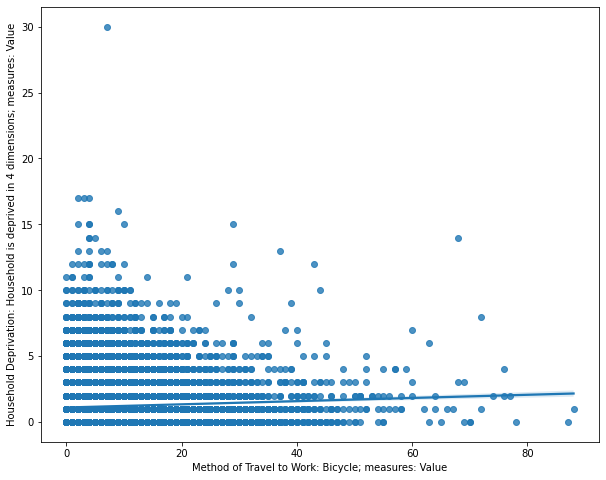

In [115]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.regplot(data = df, x="Method of Travel to Work: Bicycle; measures: Value", 
            y="Household Deprivation: Household is deprived in 4 dimensions; measures: Value", ax=ax)
                       
plt.show()

Regression plot reveals no majour relationship. Suggesting it is unlikely that deprevation of 

#### 4.1.2 Cycle to work and Pollution

In [11]:
#Cycle to work proportion
df["ctw_prop"]  = df["Method of Travel to Work: Bicycle; measures: Value"] / df["Method of Travel to Work: All categories: Method of travel to work; measures: Value"] 

In [12]:
#Deprivation on 4 dimensions proportion
df["dep4_prop"]  = df["Household Deprivation: Household is deprived in 4 dimensions; measures: Value"] / df["Method of Travel to Work: All categories: Method of travel to work; measures: Value"] 

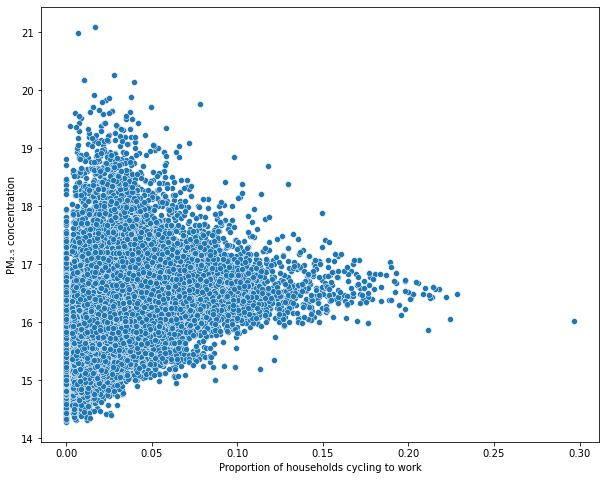

In [17]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.scatterplot(data = df, x="ctw_prop", 
            y="PM252013me", ax=ax)

plt.ylabel("PM\u2082.\u2085 concentration")
plt.xlabel("Proportion of households cycling to work")
plt.show()

TypeError: plot got an unexpected keyword argument 'x'

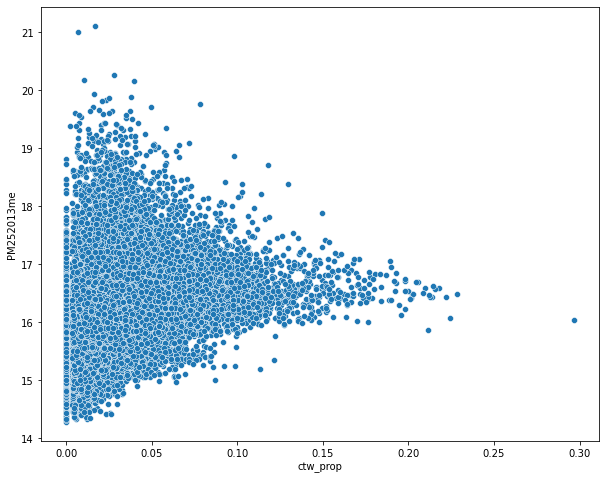

In [116]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.scatterplot(data = df, x="ctw_prop", 
            y="PM252013me", ax=ax)

plt.ylabel("PM\u2082.\u2085 concentration")
plt.xlabel("Proportion of households cycling to work")
plt.show()

In [20]:
df[df["ctw_prop"] >0.25]

,date_x,geography_x,geography code,Rural Urban_x,Method of Travel to Work: All categories: Method of travel to work; measures: Value,Method of Travel to Work: Work mainly at or from home; measures: Value,"Method of Travel to Work: Underground, metro, light rail, tram; measures: Value",Method of Travel to Work: Train; measures: Value,"Method of Travel to Work: Bus, minibus or coach; measures: Value",Method of Travel to Work: Taxi; measures: Value,...,Household Deprivation: Household is not deprived in any dimension; measures: Value,Household Deprivation: Household is deprived in 1 dimension; measures: Value,Household Deprivation: Household is deprived in 2 dimensions; measures: Value,Household Deprivation: Household is deprived in 3 dimensions; measures: Value,Household Deprivation: Household is deprived in 4 dimensions; measures: Value,OA11CD,LAD11NM,PM252013me,ctw_prop,dep4_prop
1095,2011,E00008930,E00008930,Total,172,9,16,3,22,0,...,39,22,15,8,0,E00008930,Hackney,16.027629,0.296512,0.0


#### 4.1.3 Cycling to Deprivation

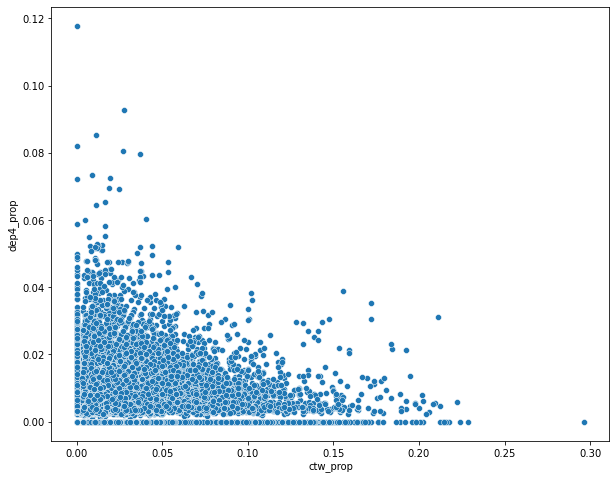

In [16]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.scatterplot(data = df, x="ctw_prop", 
            y="dep4_prop", ax=ax)
                       
plt.show()

In [39]:
df1 = df[["OA11CD", "LAD11NM", "PM252013me", "ctw_prop", "dep4_prop"]]

In [42]:
df2 = df[["PM252013me", "ctw_prop", "dep4_prop"]]

Testing correlation

Text(0.5, 1.0, 'Correlation Matrix')

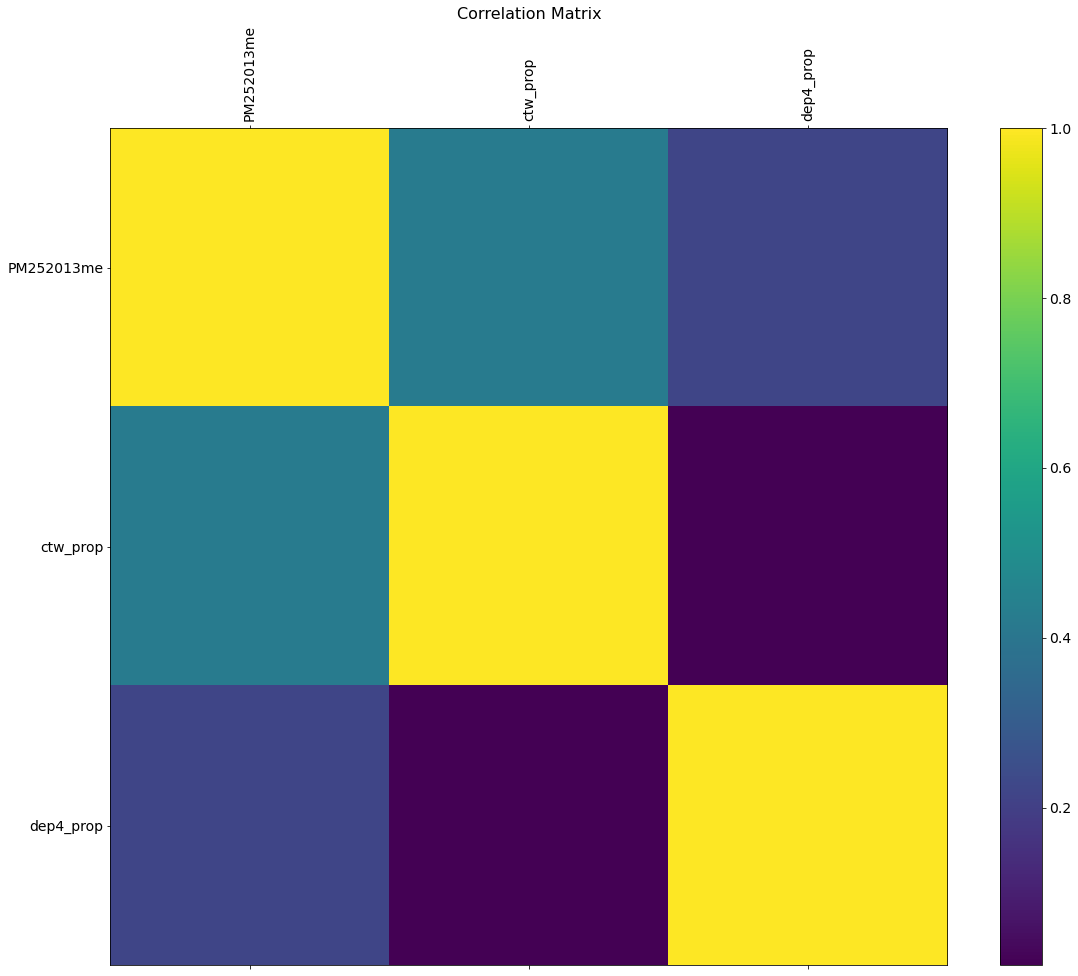

In [43]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df2.corr(), fignum=f.number)
plt.xticks(range(df2.shape[1]), df2.columns, fontsize=14, rotation=90)
plt.yticks(range(df2.shape[1]), df2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

No correlation present/ found

In [47]:
model_cnt_aq_dep = ols('ctw_prop ~ PM252013me + dep4_prop', df1).fit()
model_cnt_aq_dep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ctw_prop   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     2903.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:05:12   Log-Likelihood:                 56321.
No. Observations:               25053   AIC:                        -1.126e+05
Df Residuals:                   25050   BIC:                        -1.126e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2288      0.003    -68.213      0.000      -0.235      -0.222
PM252013me     0.0161      0.000     76.152      0.000       0.016       0.016
dep4_prop     -0.3287      0.023    -14.354      0.000      -0.374      -0.284
==============================================================================
Omnibus:                    10346.599   Durbin-Watson:                   0.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61846.854
Skew:                           1.896   Prob(JB):                         0.00
Kurtosis:                       9.698   Cond. No.                     2.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


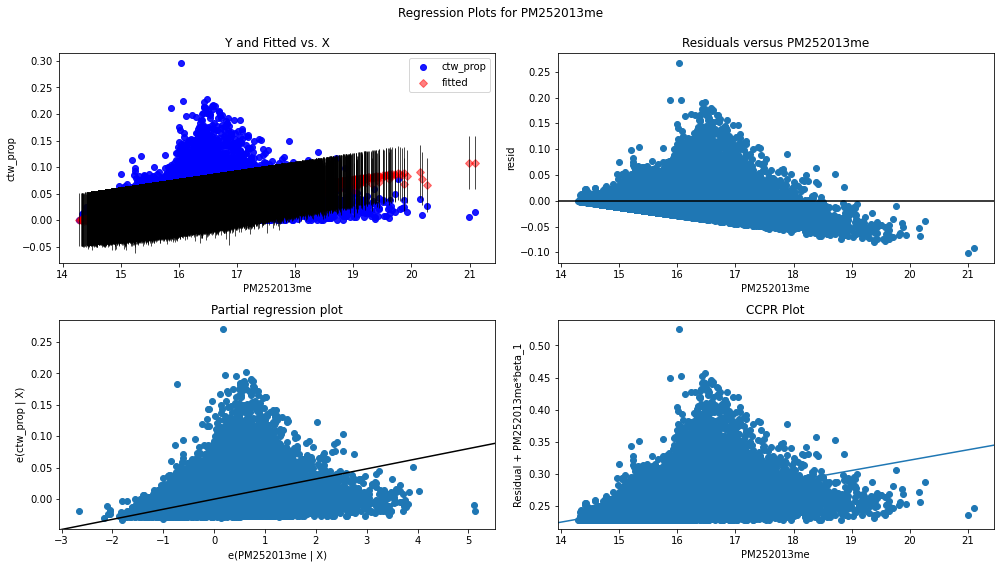

In [49]:
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model_cnt_aq_dep, 'PM252013me', fig=fig)

### Train test split

In [105]:
x_train, x_test,y_train,y_test = train_test_split(df1["ctw_prop"],df1["PM252013me"],test_size =0.2)

In [87]:
#clf.predict(np.array(x_test).reshape(1,-1))

In [107]:
olsmod = sm.OLS(y_train, x_train)
olsres = olsmod.fit()
print(olsres.summary())

                                 OLS Regression Results                                
Dep. Variable:             PM252013me   R-squared (uncentered):                   0.485
Model:                            OLS   Adj. R-squared (uncentered):              0.485
Method:                 Least Squares   F-statistic:                          1.884e+04
Date:                Mon, 05 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:23:54   Log-Likelihood:                         -77359.
No. Observations:               20042   AIC:                                  1.547e+05
Df Residuals:                   20041   BIC:                                  1.547e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [108]:
ypred = olsres.predict(x_test)

<AxesSubplot:xlabel='PM252013me'>

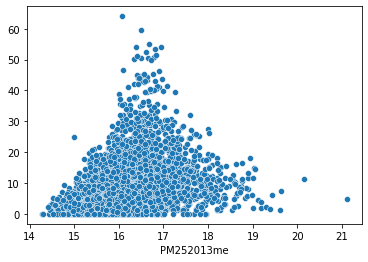

In [111]:
sns.scatterplot(x=y_test, y = ypred)

In [124]:
type(y_test)

pandas.core.series.Series

In [127]:
y_test = np.array(y_test).reshape(1,-1)
ypred = np.array(ypred).reshape(1,-1)

In [130]:
from sklearn.metrics import accuracy_score

In [131]:
accuracy_score(y_test, ypred)

ValueError: continuous-multioutput is not supported

In [57]:
model_cnt_aq_dep = ols('ctw_prop ~ PM252013me', df1).fit()
model_cnt_aq_dep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ctw_prop   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     5554.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:09:35   Log-Likelihood:                 56218.
No. Observations:               25053   AIC:                        -1.124e+05
Df Residuals:                   25051   BIC:                        -1.124e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2197      0.003    -66.433      0.000      -0.226      -0.213
PM252013me     0.0154      0.000     74.525      0.000       0.015       0.016
==============================================================================
Omnibus:                    10364.103   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61114.383
Skew:                           1.905   Prob(JB):                         0.00
Kurtosis:                       9.635   Cond. No.                         328.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 4.2. Appropriate plots to illustrate relationship between key fields

# References

Liu, C., Chen, R., Sera, F., Vicedo-Cabrera, A.M., Guo, Y., Tong, S., Coelho, M.S., Saldiva, P.H., Lavigne, E., Matus, P. and Valdes Ortega, N., 2019. Ambient particulate air pollution and daily mortality in 652 cities. New England Journal of Medicine, 381(8), pp.705-715.